In [1]:
import glob, os, sys, shutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

from bayes_opt import BayesianOptimization
from bayes_opt import UtilityFunction


%load_ext autoreload
%autoreload 2
%matplotlib inline
if os.name == 'posix':
    %config InlineBackend.figure_format = 'retina' #retina display settings

In [2]:
df = pd.read_csv(filepath_or_buffer='./train.csv', index_col='PassengerId')
df_test = pd.read_csv(filepath_or_buffer='./test.csv', index_col='PassengerId')


df.Sex = (df.Sex=='male')*1.
df_test.Sex = (df_test.Sex=='male')*1.

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df.Embarked.astype('str'))
le.classes_


df.Embarked = le.transform(df.Embarked.astype('str'))
df_test.Embarked = le.transform(df_test.Embarked.astype('str'))

df.Name = df.Name.str.contains('Mr.')*1 + df.Name.str.contains('Mrs.')*2 + df.Name.str.contains('Miss.')*3
df_test.Name = df_test.Name.str.contains('Mr.')*1 + df_test.Name.str.contains('Mrs.')*2 + df_test.Name.str.contains('Miss.')*3


df.Age.fillna(df.Age.mean(skipna=True), inplace=True)
df_test.Age.fillna(df_test.Age.mean(skipna=True), inplace=True)

df_test.Fare.fillna(df_test.Fare.mean(skipna=True), inplace=True)
#df.dropna(inplace=True)


keep_cols = ['Age', 'Sex', 'Parch', 'Fare', 'Pclass', 'Embarked', 'Name']
#keep_cols = ['Age', 'Sex', 'Fare', 'Pclass', 'Name']


X = df[keep_cols].values
X_test = df_test[keep_cols].values


X_scaled = preprocessing.scale(X)
X_test_scaled = preprocessing.scale(X_test)
y = df['Survived'].values

print(df[keep_cols+['Survived']].columns)
df[keep_cols+['Survived']].head(2)

Index(['Age', 'Sex', 'Parch', 'Fare', 'Pclass', 'Embarked', 'Name',
       'Survived'],
      dtype='object')


,Age,Sex,Parch,Fare,Pclass,Embarked,Name,Survived
PassengerId,,,,,,,,
1,22.0,1.0,0,7.2500,3,2,1,0
2,38.0,0.0,0,71.2833,1,0,3,1


In [11]:
dff = df[['Age', 'Sex', 'Fare', 'Name']+['Survived']]

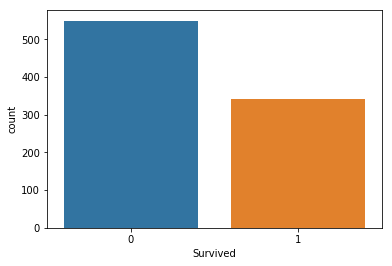

In [12]:
sns.countplot(dff['Survived'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C1E5714710>,
      dtype=object)

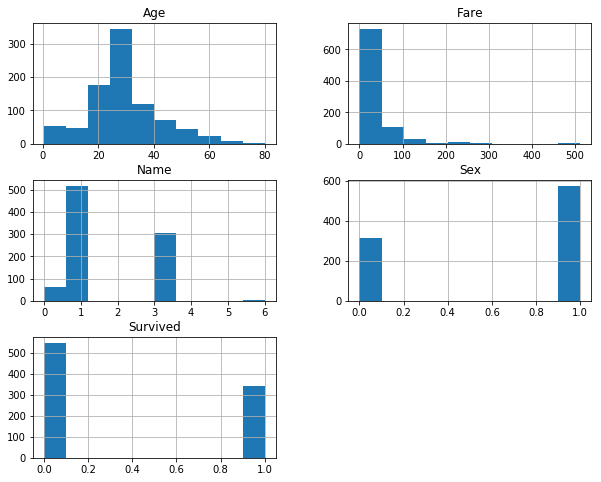

In [23]:
dff.hist(figsize=(10,8))

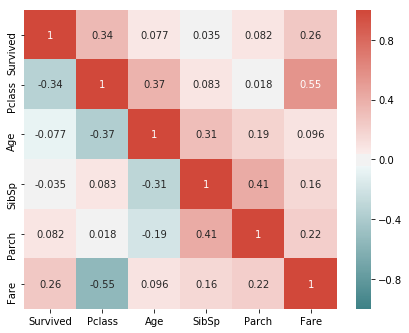

In [121]:
df = pd.read_csv(filepath_or_buffer='./train.csv', index_col='PassengerId')
corr = df.corr()
corr.values[np.triu_indices_from(corr)] = np.abs(corr.values[np.triu_indices_from(corr)] )

fig = plt.figure(figsize=(7, 5.5))
sns.heatmap(corr, annot=True, cmap=sns.diverging_palette(200, 15, as_cmap=True), vmin=-1, vmax=1)

In [180]:
def violin(df_group, labels,  covariance_factor=0.25, fig_ax=None):
    # data_up, data_down, label_up='data 1', label_down='data 2'
    from scipy.stats import gaussian_kde
    
    fig, ax = (fig_ax if fig_ax else plt.subplots(1))
    
    
    if len(labels)==2:
        for label, sign in zip(labels, [1, -1]):
            data = df_group.get_group(label)
            
            density = gaussian_kde(data)
            x = np.linspace(data.min(), data.max(), 100)
            density.covariance_factor = lambda : float(covariance_factor)
            density._compute_covariance()

            line, = ax.plot(x, sign*density(x))
            ax.fill_between(x, sign*density(x), alpha=0.3, label=str(label), color=line.get_color())
            median, mean = np.median(data), np.mean(data)
            ax.vlines([median, mean], 0, [sign*density(median), sign*density(mean)], color=line.get_color())
            ax.legend()
    else:
        for index, label in enumerate(labels):
            data = df_group.get_group(label)
            plt.violinplot(data, positions=[index],  points=20, showmeans=True, showmedians=True,vert=True)
        ax.set_xticks(range(len(labels)))
        ax.set_xticklabels(labels)

        

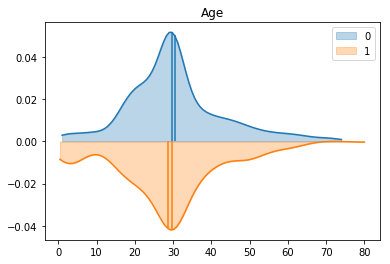

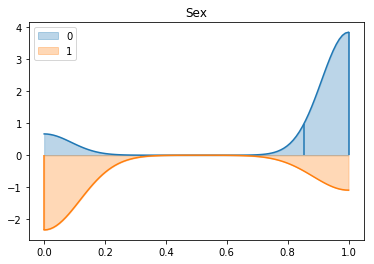

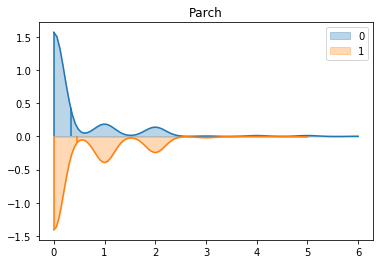

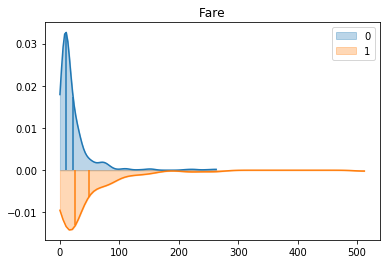

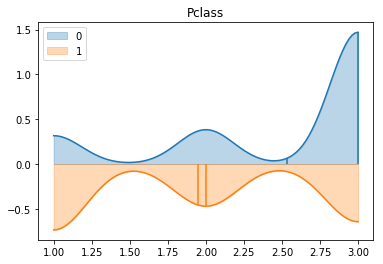

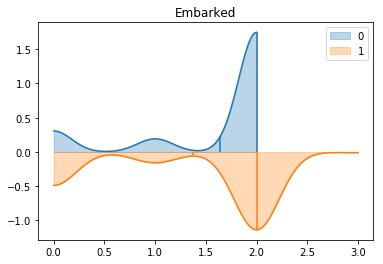

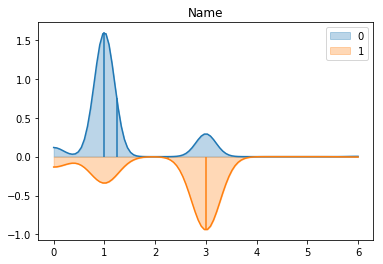

In [181]:
for column in df[keep_cols].columns:
    fig, ax = plt.subplots(1)
    violin(df.groupby('Survived')[column], labels=[0,1], fig_ax=(fig, ax))
    ax.set_title(str(column))

In [186]:
class Parameter_space(object):
    '''Scale points for bayes_opt library.
    '''
    def __init__(self, bounds={}):
        ''' Set the hyper-rectangle boundary for Bayes optimization.
        
        Set up the boundaries of the parameter space, defining both the min-max limits and the 
        scale: linear, log or descrete.
        
        The linear scale maps the min-max interval to [0, 1] and vice versa.
        The descrete scale maps the min-max integer interval to float [0, 1]. The opposite
        conversion will map the float [0, 1] to the integer [min, max] interval.
        The log scale maps the [min, max] interval to [0, 1]. The opposite conversion maps
        the [0, 1] interval to [10^min, 10^max] interval.
        
        Example:
            ps = Parameter_space({'a': (-2, 2, 'lin'),
                                  'b': (0, 20, 'descrete'),
                                  'c': (-8, 0, 'log')})
            
        
        Args:
            bounds (dict): boundaries dictionary: keys are the name of the parameters, values tuples
                containing (min parameter value, max parameter value, sampling scale). The sampling scale can be: 'linear',
                'logarithmic' or 'descrete'. For the logarithmic scale, the  min and max parameter values must be
                provided as base 10 exponents: (e.g. 4 means 1e4)
        
        '''
        self.bounds = bounds
        for k, v in self.bounds.items():
            assert (v[2] in ('lin', 'linear', 'int', 'integer', 'descrete', 'log', 'logarithmic')),\
            "Set the scale using 'lin', 'descrete', or 'log'"
        
    def _remap(self, x, in_min, in_max, out_min, out_max):
        ''' Linearly maps a float interval from [in_min, in_max] to [out_min, out_max].
        '''
        return (x-in_min) * (out_max-out_min) / (in_max-in_min) + out_min
    
    def get_01(self):
        ''' Helper function which provides the pbounds parameter required by the BayesianOptimization class.
        Example:
            ps = Parameter_space({'a': (-2, 2, 'lin'),
                      'b': (0, 20, 'descrete'),
                      'c': (-8, 0, 'log')})
            ps.get_01() returns {'a': (0, 1), 'b': (0, 1), 'c': (0, 1)}
            
            A use case withing the bayes_opt library might be:
            optimizer = BayesianOptimization(
                f=test_function,
                pbounds=ps.get_01(),
                verbose=2,
                random_state=30)
        '''
        return {k:(0, 1) for k in self.bounds.keys()}
    
    def scaled(self, point):
        ''' Scale points from [min, max] interval to [0, 1].
        Args:
            point(dict): Dictionary describing a point in the parameter space [min,max]. Keys are the parameters names 
                and values correspond to the parameter value.
            
        Returns:
            new_point(dict): Input parameter space point mapped to [0, 1] range.
        '''
        new_point = {}
        for k, v in self.bounds.items():
            if v[2] in ('lin', 'linear'):
                new_point[k] = self._remap(point[k], v[0], v[1], 0, 1)
            elif v[2] in ('int', 'integer', 'descrete'):
                new_point[k] = self._remap(point[k], v[0], float(v[1]), 0, 1)
            elif v[2] in ('log', 'logarithmic'):
                new_point[k] = self._remap(np.log10(point[k]), v[0], v[1], 0, 1)
            else:
                raise ValueError("Set the scale using 'lin', 'descrete', or 'log'")
        return new_point
    
    def original(self, point):
        ''' Scale points from [0, 1] interval to [min, max].
        Args:
            point(dict): Dictionary describing a point in the parameter space [0,1]. Keys are the parameters names 
                and values correspond to the parameter value.
            
        Returns:
            new_point(dict): Input parameter space point mapped to [min, max] range.
        '''
        new_point = {}
        for k, v in self.bounds.items():
            if v[2] in ('lin', 'linear'):
                new_point[k] = self._remap(point[k], 0, 1, v[0], v[1])
            elif v[2] in ('int', 'integer', 'descrete'):
                new_point[k] = round(self._remap(point[k], 0, 1, v[0], v[1]))
            elif v[2] in ('log', 'logarithmic'):
                
                new_point[k] = 10**self._remap(point[k], 0, 1, v[0], v[1])
            else:
                raise ValueError("Set the scale using 'lin', 'descrete', or 'log'")                  
        return new_point
    
    def get_plot_scale(self, key):
        '''Get scale of a given parameter.
        
        Args:
            key(string): name of the parameter.
        
        Returns:
            scale(string): 'log' or 'linear' depending on the parameter scale .
        '''
        scale = self.bounds[key][2]
        return 'log' if scale in ('log', 'logarithmic') else 'linear'
    
    def array_to_original(self, arr, key_order):
        '''Maps a full array from [0, 1] to the [min, max].
        
        Args:
            arr(np.array): numpy array containing the parameters space coordinates as rows
            key_order(list): Parameter labels corresponding to the columns of the numpy array.
        
        Returns:
            new_arr(numpyy_array): numpy array with scaled coordinates to [min, max] interavl
                for each column og the input array.        
        '''
        new_arr = np.ones(arr.shape)
        for index, point in enumerate(arr):
            scaled_point = {k: point[i] for i, k in enumerate(key_order)}
            new_point = self.original(scaled_point)
            new_arr[index, :] = np.array([new_point[k] for k in key_order])
            
        return new_arr
    
    def optimizer_to_lists(self, optimizer, key_order):
        new_arr = np.ones([len(optimizer.res), len(key_order)+1])       
        for index, point in enumerate(optimizer.res):
            original_point = self.original(point['params'])            
            for param_index, param_name in enumerate(key_order):
                new_arr[index, param_index] = original_point[param_name]
            new_arr[index, -1] = point['target']
        return [new_arr[:,i] for i in range(new_arr.shape[1])]
    
    def optimizer_to_grid(self, optimizer, key_order):
        _ = optimizer.suggest(utility)
        
        x_span = np.linspace(0,1,50)
        y_span = np.linspace(0,1,50)
        
        xy_meshgrid = np.meshgrid(x_span, y_span, indexing='xy')
        xy_shape = xy_meshgrid[0].shape
        xy = np.column_stack([np.ravel(x) for x in xy_meshgrid])
        mean, sigma = optimizer._gp.predict(xy, return_std=True)
        new_key_order = [optimizer.space.keys.index(key) for key in key_order]
        xy_orig = ps.array_to_original(xy, optimizer.space.keys)
        x_grid = xy_orig[:, new_key_order[0]].reshape(xy_shape)
        y_grid = xy_orig[:, new_key_order[1]].reshape(xy_shape)
        mean = mean.reshape(xy_shape)
        sigma = sigma.reshape(xy_shape)
        
        return x_grid, y_grid, mean, sigma
    
    def plot_optimizer(self, optimizer, key_order, fig_axs=None):
        
        fig, axs = fig_ax if fig_axs else plt.subplots(1, 2, figsize=(10,5))
        
        X_PARAM = key_order[0]
        Y_PARAM = key_order[1]

        x_grid, y_grid, mean, sigma = ps.optimizer_to_grid(optimizer, key_order=[X_PARAM, Y_PARAM])
        X_points, Y_points, targets = ps.optimizer_to_lists(optimizer, key_order=[X_PARAM, Y_PARAM])

        axs[0].contourf(x_grid, y_grid, mean, 50, zorder=1)
        axs[0].set_title('Mean')
        axs[1].contourf(x_grid, y_grid, sigma, 50, zorder=1)
        axs[1].set_title('Sigma')

        x_max, y_max =  optimizer.max['params'][X_PARAM], optimizer.max['params'][Y_PARAM]
        
        for ax in axs:
            ax.scatter(X_points, Y_points, c=targets, cmap='magma', zorder=4, marker='d')
            ax.scatter(x_max, y_max, color='red', zorder=1, marker='o', alpha=0.5, s=150)

            ax.set_xlim(min(X_points), max(X_points))
            ax.set_ylim(min(Y_points), max(Y_points))
                       
            ax.set_xscale(ps.get_plot_scale(X_PARAM))
            ax.set_yscale(ps.get_plot_scale(Y_PARAM))

            ax.set_xlabel(f'{X_PARAM} (max: {x_max:.2e})')
            ax.set_ylabel(f'{Y_PARAM} (max: {y_max:.2e})')


# ps = Parameter_space({'a': (-2, 2, 'lin'),
#                       'b': (0, 20, 'descrete'),
#                       'c': (-8, 0, 'log')})


# point = {'a':15, 'b':1, 'c':1e-4}
# print(point)
# new_point = ps.scaled(point)
# print(new_point)
# new_point = ps.original(new_point)
# print(new_point)

# x_span = np.linspace(0,1,20)
# y_span = np.linspace(0,1,20)
# z_span = np.linspace(0,1,20)

# xx, yy, zz = np.meshgrid(x_span, y_span, z_span)
# xyz = np.concatenate(np.meshgrid(x_span, y_span, z_span)).reshape(-1, 3, order='F')

# aaa = ps.array_to_original(xyz, ['a', 'b', 'c'])

In [187]:
from sklearn.model_selection import cross_val_score
from sklearn import svm

clf = svm.SVC(**{'gamma': 0.13981542356819526, 'C': 0.09512341470096693})
scores = cross_val_score(clf, X_scaled, y, cv=5)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

clf_final = svm.SVC(gamma=0.02, C=73)
clf_final.fit(X_scaled, y)
y_test = clf_final.predict(X_test_scaled)

df_submission = pd.DataFrame({'PassengerId':df_test.index.values,
                             'Survived':y_test})

df_submission.to_csv('to_grade.csv', index=False)

Accuracy: 0.79 (+/- 0.03)


In [188]:
def test_svc(point):
    clf = svm.SVC(gamma=point['gamma'], C=point['C'])
    scores = cross_val_score(clf, X_scaled, y, cv=5)
    return scores.mean()

In [189]:
ps = Parameter_space({'a': (-2, 2, 'lin'),
          'b': (0, 20, 'descrete'),
          'c': (-8, 0, 'log')})
ps.get_01()

{'a': (0, 1), 'b': (0, 1), 'c': (0, 1)}

In [190]:
ps = Parameter_space({'gamma': (-4, 4, 'log'),
                      'C': (-3, 4, 'log')})

optimizer = BayesianOptimization(
    f=test_svc,
    pbounds=ps.get_01(),
    verbose=2,
    random_state=30)


utility = UtilityFunction(kind="ucb", kappa=1., xi=None)

In [191]:

def progress_bar(current_value, max_value):
    progress = ((current_value+1)/max_value)*100
    if progress>98: progress=100
    print('\r[{0}{1}] {2:.1f}%'.format('#'*int(progress/2), ' '*(50-int(progress/2)), progress), end='')


ITERATIONS = 300
for index in range(ITERATIONS):
    #next_point_to_probe = optimizer.suggest(utility)
    next_point_to_probe = optimizer.space.array_to_params(optimizer.space.random_sample())
    target = test_svc(ps.original(next_point_to_probe))
    #print(ps.original(next_point_to_probe), 'Acc: ', target)
    optimizer.register(params=next_point_to_probe, target=target)
    progress_bar(index, ITERATIONS)

[##################################################] 100.0%

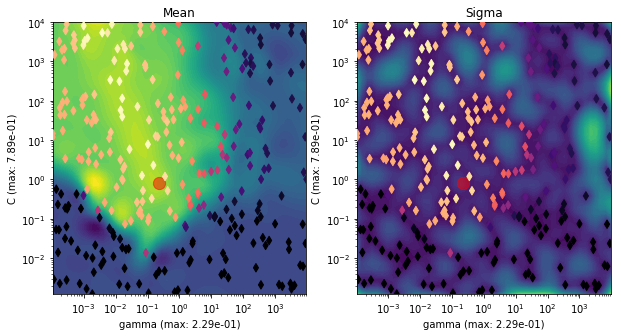

In [192]:
ps.plot_optimizer(optimizer, ['gamma', 'C'])

(0.001218920729221652, 9830.938827375)

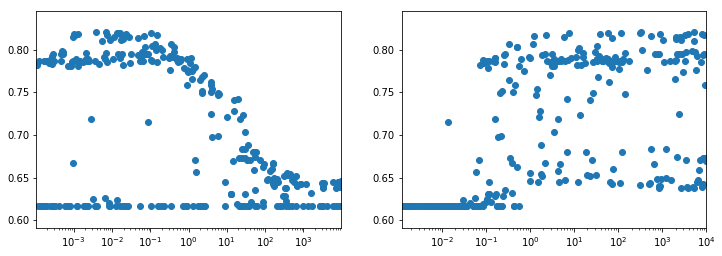

In [211]:
X_points, Y_points, targets = ps.optimizer_to_lists( optimizer, ['gamma', 'C'])


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.scatter(X_points, targets)
ax1.set_xscale('log')
ax1.set_xlim([f(X_points) for f in [np.min, np.max]])

ax2.scatter(Y_points, targets)
ax2.set_xscale('log')
ax2.set_xlim([f(Y_points) for f in [np.min, np.max]])



In [195]:
print(optimizer.max['params'])
test_svc(optimizer.max['params'])

{'C': 0.7894106003995638, 'gamma': 0.22912990202758132}


0.815966879767869

In [194]:
clf_final = svm.SVC(gamma=0.23, C=0.79)
clf_final.fit(X_scaled, y)

y_training = clf_final.predict(X_scaled)
print(f'training accuracy: {np.sum(y_training==y)/len(y)}')


y_test = clf_final.predict(X_test_scaled)

df_submission = pd.DataFrame({'PassengerId':df_test.index.values,
                             'Survived':y_test})

df_submission.to_csv('to_grade.csv', index=False)

training accuracy: 0.8327721661054994
